# Approximation through the empirical interpolation method (EIM)

The empirical interpolation method (EIM) seeks to approximate a family of parametric functions using a sensibly chosen linear space of moderate dimension, and some interpolation points. Any function in this parametric family can then be approximated globally by simply evaluating it at the interpolation points, then filling in using the linear interpolator.

<img src="./interp_example.png">

This Notebook demo performs EIM on a simple example parametric function using only code from this Notebook. There are some crucial steps left to fill in, as an exercise for the workshop participant.

### First we need to do a little housekeeping

We import the libraries we require:

In [1]:
import numpy as np
from IPython.display import Latex, display

import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

This following snippet stops the automatic truncation of cell output when it gets too long:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Let us define a little helper function for plotting our functions on grids

In [3]:
cmap = cm.inferno

def plot_R2_function(vals, ax, title=None, alpha=0.7):
    # A routine that just plots a function that is assumed to be evaluated 
    # on a the grid of points - vals is assumed to be a square array
    # (note that x1_grid and x2_grid will be defined below)
    wframe = ax.plot_surface(x1_grid, x2_grid, vals, cstride=5, rstride=5, 
                             alpha=alpha, cmap=cmap)
    
    ax.set_facecolor('white')
    if title is not None:
        ax.set_title(title)

# Step 1 - Lets get started! 
### First we need to define a family of functions that we want to interpolate

Lets start with a simple family of parametric functions given by

$$\large
y(x, \mu) = \frac{2}{\| x - \mu \|}
$$

where $\large x \in \mathcal{D} = [0,1]^2$ is two dimensional, and the parameter  $\large \mu \in \mathcal{U} = [1.1, 2.1]^2$.

(We can define whatever we want for $\mathcal{D}$ in ```x_lims``` or for $\mathcal{U}$ in  ```mu_lims```)

Below we define a grid for $x$ on $\mathcal{D} = [0,1]^2$, and a grid of possible parameters $\mu$ in $\mathcal{U} = [1.1, 2.1]^2$.

In [4]:
x_lims = [[0,1], [0,1]]
mu_lims = [[1.1, 2.1], [1.1, 2.1]]

n_x_grid = 100
n_mu_grid = 100

mu1_grid, mu2_grid = np.meshgrid(np.linspace(mu_lims[0][0], mu_lims[0][1], n_mu_grid+1, endpoint=True), 
                                 np.linspace(mu_lims[1][0], mu_lims[1][1], n_mu_grid+1, endpoint=True))
x1_grid, x2_grid = np.meshgrid(np.linspace(x_lims[0][0], x_lims[0][1], n_x_grid+1, endpoint=True), 
                               np.linspace(x_lims[1][0], x_lims[1][1], n_x_grid+1, endpoint=True))

# We make a flattened list of all the points in the grid for x or mu
# If we call mu_grid_list[i] we will get an array of length 2, [mu_1, mu_2] 
mu_grid_list = np.vstack((mu1_grid.flatten(), mu2_grid.flatten())).T
x_grid_list = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

# Just how many possible parameters have we generated?
print('Number of mu parameters in grid:', mu_grid_list.shape[0])

Number of mu parameters in grid: 10201


<IPython.core.display.Latex object>

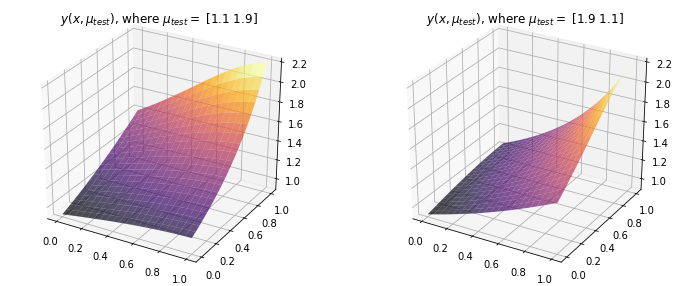

In [5]:
def y(x, mu):
    # This definition of y can take a list of multiple values for x or mu
    # (because of the behaviour of np.linalg.norm with axis=1)
    return 2.0 / np.linalg.norm(x - mu, axis=1)

def eval_y_on_grid(mu):
    # This evaluates y on the grid using the pre-computed x_grid_list
    return y(x_grid_list, mu).reshape((n_x_grid+1, n_x_grid+1))

display(Latex(r'We plot two instances of $y(x,\mu)$'))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
mu_test = np.array([1.1, 1.9])
plot_R2_function(eval_y_on_grid(mu_test), ax, 
                 title=rf'$y(x,\mu_{{test}})$, where $\mu_{{test}} = $ {mu_test}')

ax = fig.add_subplot(1, 2, 2, projection='3d')
mu_test = np.array([1.9, 1.1])
plot_R2_function(eval_y_on_grid(mu_test), ax, 
                 title=rf'$y(x,\mu_{{test}})$, where $\mu_{{test}} = $ {mu_test}')
plt.show()

# Step 2: Generate a training set 

We evaluate the function $y(x, \mu)$ for each $\mu$ in a set of parameters $\mathcal{T} \subset \mathcal{U}$. 

We can take $\mathcal{T}$ to simply be the list of grid points ```mu_grid_list```, defined earlier. These evaluations of $y(x, \mu_i)$ are saved in ```training_set```.

The number of training set points $N$ is determined by the grid we defined earlier...

In [6]:
# This is the training set: a collection of g evaluated for every mu in mu_grid_list
training_set = [eval_y_on_grid(mu) for mu in mu_grid_list]

N = len(training_set)
print('N =', N, 'is the number of training set points')
print('Element 0 is a NumPy array of dimension', training_set[0].shape)

N = 10201 is the number of training set points
Element 0 is a NumPy array of dimension (101, 101)


# Step 3 - Define routines to assemble $\mathbf{B}$ and the interpolation $\mathcal{I}_n(g)$

The interpolator that we wish to construct is a linear system of the form

$$
\large
\mathcal{I}_n( y(x, \mu) ) = \sum_{j=1}^n {\alpha_j(\mu)} \, { q_j(x)}
$$

This matrix is used in the next step of evaluating the interpolator $\mathcal{I}_n(q)$. We require our interpolation scheme to be exact on the interpolation points $(x_i)_{i=1}^n$, that is we require
$$
\large
\mathcal{I}_n( y(x_i, \mu) ) = y(x_i, \mu)
$$

This means that we enforce
$$
\large
\sum_{j=1}^n \alpha_j(\mu) \, q_j(x_i) = y(x_i, \mu)
$$
which is equivalent to the linear system
$$
\large
\mathbf{B} \mathbf{\alpha} = \mathbf{y}
$$

where $\mathbf{B} \in \mathbb{R}^{n\times n}$ and $\mathbf{\alpha}, \mathbf{y} \in \mathbb{R}^n$ are the matrix and coefficient vectors with values

$$\large
\begin{aligned}
(\mathbf{B})_{i,j} &= q_j(x_i) \\[5pt]
(\mathbf{y})_i &= y(x_i, \mu) \\[5pt]
(\mathbf{\alpha})_j &= \alpha_j(\mu).
\end{aligned}
$$

Thus we see there are __two__ crucial steps in EIM. As such, we will define two routines:
 - ```build_B_matrix``` that constructs $\mathbf{B}$, and
 - ```interpolator``` that calculates $\mathcal{I}_n[y(x, \mu)]$, it takes the inverse $\mathbf{B}^{-1}$ and uses it to calculate the $\alpha_i(\mu)$, which are labelled ```alpha_coeffs[i]``` in the code. To calculate ```alpha_coeffs``` we require the function evaluations $y(x_i, \mu)$ which are stored in ```func_eval[i]```.
 
__Question__: Why would we define $\mathbf{B}$ separately and then use its inverse $\mathbf{B}^{-1}$, rather than just calling a linear solver line ```np.linalg.solve```?

In [7]:
def build_B_matrix(interp_funcs, interp_points):

    # ===================
    #  FILL IN CODE HERE
    # ===================
    # Make the B matrix. Use np.zeros() to define a matrix of zeros
    # Assume interp_funcs is a list [] of square arrays and
    # interp_points is a list [] of 2-element arrays that are 
    # indices for those square arrays
    B = np.zeros((len(interp_points), len(interp_funcs)))
    for i in range(len(interp_points)):
        for j in range(len(interp_funcs)):
            B[i, j] = interp_funcs[j][interp_points[i]]
            
    return B

def interpolator(func, B_inv, interp_funcs, interp_points):
    
    # ===================
    #  FILL IN CODE HERE
    # ===================
    # 1. Evaluate func at the interp_points, store in func_evals
    #
    # 2. Find the coefficients alpha from B_inv and these func_evals
    #
    # 3. Build the interpolant by mulitplying alpha[i] by the interp_funcs
    
    # 1. First we must evaluate g at the interp_points
    func_eval = np.zeros(len(interp_points))
    for i, interp_point in enumerate(interp_points):
        # N.B. We call func[inter_point] as it is an array of function evaluations on a grid
        # (In some other setting func we may actually want func(inter_point))
        func_eval[i] = func[interp_point] 

    # 2. Now we apply B_inv to be able to calculate the EIM coefficients
    # (note the use of the @ symbol which means matrix-multiplication in Python 3.5+)
    alpha_coeffs = B_inv @ func_eval
    interpolant = np.zeros(func.shape)
    
    # 3. We construct the interpolant from these coefficients
    for i in range(len(interp_points)):
        interpolant += alpha_coeffs[i] * interp_funcs[i]
    
    return interpolant

# Step 4 - implement the iterations of the EIM

### The first iteration:

$$ \large
\begin{aligned}
\mu_1 &= {\arg \max}_{\mu \in \mathcal{T}} \| y(x, \mu) \| \\[5pt]
x_1 &= {\arg \max}_{x \in \mathcal{D}} | y(x, \mu_1) | \\[5pt]
q_1 &= \frac{y(x, \mu_1)} { y(x_1, \mu_1)}
\end{aligned}
$$

Note that we are saving the interpolation functions $\large q_i$ in the list ```interp_funcs``` and the interpolation points $\large x_i$ in the list ```interp_points```.

First we define helper functions that gives us the __location__ of the maximum of an array of function values ```func```, as well as the $L^2$ and $L^\infty$ norms.

In [8]:
def argmax_2d(func):
    # this returns the indices of where the maximum is located in a 2-d array
    # necessary due to the standard behaviour of NumPy's argmax() function
    return np.unravel_index(np.argmax(func), func.shape)

In [9]:
def norm(func_vals):
    # A little helper function that calculates the L^2 norm of a function that
    # is evaluated on the regular x grid.
    return np.linalg.norm(func_vals) / (n_x_grid * n_x_grid)

def L_inf_norm(func_vals):
    return func_vals.max()

<IPython.core.display.Latex object>

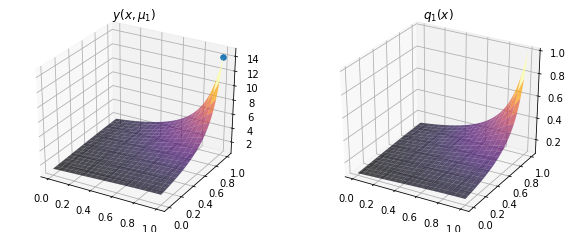

<IPython.core.display.Latex object>

In [10]:
selected = []
interp_funcs = []
interp_points = []

# ===================
#  FILL IN CODE HERE
# ===================
# How do we make the first choice for mu_1 and x_1? Review the notes above.
# We need to find argmax of the norms of each member of the training set.
# You could use np.argmax( ) for example...
norms = np.array([norm(u) for u in training_set])
first_choice = np.argmax(norms) # ??? 
first_x = argmax_2d(training_set[first_choice]) # ???

# Now we add our first selection and the first interpolation point 
# to the list
selected.append(first_choice)
interp_points.append(first_x)

# ===================
#  FILL IN CODE HERE
# ===================
# We want to "normalise" our first choice of function to obtain the first 
# interpolation function q_i
interp_funcs.append(training_set[first_choice] / training_set[first_choice][first_x])

# Lets take a look at what we've chosen
display(Latex(r'We plot the first choice $y(x, \mu_1)$, and label $x_1$, as well as $q_1(x)$'))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_R2_function(training_set[first_choice], ax, title = rf'$y(x, \mu_1)$')
ax.scatter(first_x[1] / n_x_grid, first_x[0] / n_x_grid, training_set[first_choice][first_x], s=30)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_R2_function(interp_funcs[-1], ax, title = rf'$q_1(x)$')
plt.show()

display(Latex(rf'The point $x_{1}$ is at index {first_x} which ' +
              rf'gives the coordinate $x_{1} = {{{first_x[1]/n_x_grid, first_x[0]/n_x_grid}}}$ ' +
              rf'(marked by the blue dot)'))


### Then at iteration $n$

Assume we have built a collection of interpolation functions $(q_1,\ldots,q_{n-1})$ and interpolation points $(x_1,\ldots,x_{n-1})$. From these we can define $\mathcal{I}_{n-1}[y(x, mu)]$ as in __Step 3__. Then we find

$$ \large
\begin{aligned}
\mu_n &= {\arg \max}_{\mu \in \mathcal{T}}  \| y(x, \mu) - \mathcal{I}_{n-1}[ y(x, \mu) ] \| \\[5pt]
x_n &= {\arg \max}_{x\in\mathcal{D}} | y(x, \mu_n) | \\[5pt]
q_n &= \frac{y(x, \mu_n) - \mathcal{I}_{n-1}[y(x, \mu_n)]} { y(x_n, \mu_n) - \mathcal{I}_{n-1}[y(x_n, \mu_n)]}
\end{aligned}
$$

We must use the two routines we defined earlier: 
 - ```build_B_matrix(interp_funcs, interp_points)``` and 
 - ```interpolator(func, B_inv, interp_funcs, interp_points)```

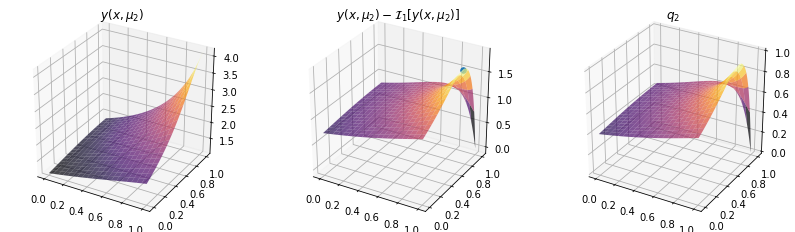

<IPython.core.display.Latex object>

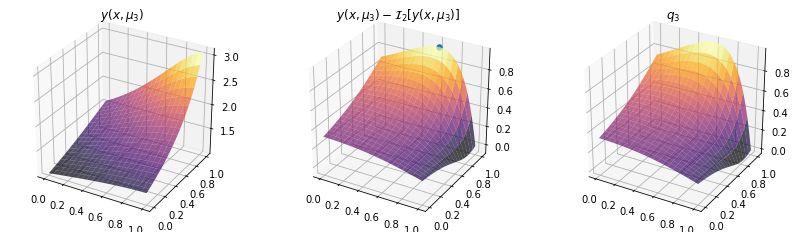

<IPython.core.display.Latex object>

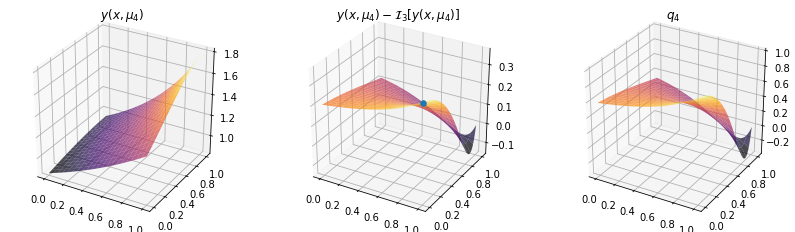

<IPython.core.display.Latex object>

In [11]:
n_iter = 10 # The number of iterations = num of interpolation points and functions

# We need to calculate the initial B matrix (it is only a 1x1 matrix, but still...)
B = build_B_matrix(interp_funcs, interp_points)
B_inv = np.linalg.inv(B)

for n in range(2,n_iter+1):
    
    # Now we can construct the vector for each function
    resids = np.zeros(len(training_set))
    # ===================
    #  FILL IN CODE HERE
    # ===================
    # We want to calculate the norm of the "residual" from the interpolation
    # of each member of the training set
    for func_i, func in enumerate(training_set):
        # Here we see why we calculated B_inv: because we to the same inversion many times over
        # over the whole training set
        interpolant = interpolator(func, B_inv, interp_funcs, interp_points)
        resids[func_i] = norm(func - interpolant)
    
    next_choice = np.argmax(resids)
    selected.append(next_choice)
    
    selected_func = training_set[next_choice]
    selected_func_resid = selected_func - interpolator(selected_func, B_inv, interp_funcs, interp_points)
    
    # Now choose x_n - note that it is an index of where the maximum is located on the grid
    next_x = argmax_2d(selected_func_resid)
    interp_points.append(next_x)
    
    # ===================
    #  FILL IN CODE HERE
    # ===================
    # We want to "normalise" our first choice of function to obtain the first 
    next_q = selected_func_resid / selected_func_resid[next_x]
    interp_funcs.append(next_q)

    # ===================
    #  FILL IN CODE HERE
    # ===================
    # We now need to update the B matrix (and B_inv as well...)
    # For further use in the next iteration and beyond...
    B = build_B_matrix(interp_funcs, interp_points)
    B_inv = np.linalg.inv(B)
    
    # Plot our results for each iteration:
    if n < 5:
        fig = plt.figure(figsize=(14, 4))
        ax = fig.add_subplot(1, 3, 1, projection='3d')
        plot_R2_function(training_set[next_choice], ax, title = rf'$y(x, \mu_{{{n}}})$')
        ax = fig.add_subplot(1, 3, 2, projection='3d')
        plot_R2_function(selected_func_resid, ax, 
                         title = rf'$y(x, \mu_{{{n}}}) - \mathcal{{I}}_{{{n-1}}}[y(x, \mu_{{{n}}})]$')

        ax.scatter(next_x[1] / n_x_grid, next_x[0] / n_x_grid, selected_func_resid[next_x], s=30)
        ax = fig.add_subplot(1, 3, 3, projection='3d')
        plot_R2_function(interp_funcs[-1], ax, title = rf'$q_{{{n}}}$')
        plt.show()

        display(Latex(rf'The point $x_{{{n}}}$ is at index {next_x} which ' +
                      rf'gives the coordinate $x_{{{n}}} = {{{next_x[1]/n_x_grid, next_x[0]/n_x_grid}}}$'))

# Step 5 - Lets look at the results

### First lets consider using the interpolator $\mathcal{I}_n$ that we have built so far to interpolate various other functions.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

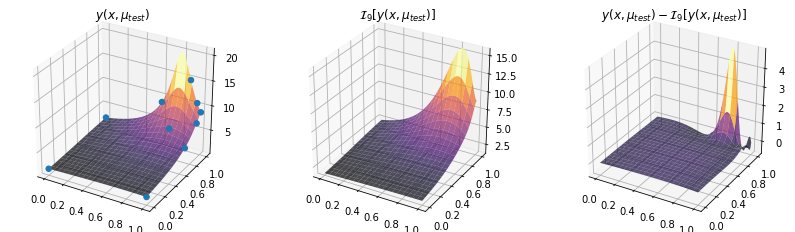

In [13]:
# Lets choose some arbitrary value for \mu (within the range that we trained our interpolator!)
mu_test = np.array([0.8, 1.1])
y_test = eval_y_on_grid(mu_test)
y_test_interp = interpolator(y_test, B_inv, interp_funcs, interp_points)

display(Latex(rf'$\mu_{{test}} = $ {mu_test}'))
display(Latex(rf'$\| y(x,\mu_{{test}}) - \mathcal{{I}}_{{{n-1}}}[y(x, \mu_{{test}})] \|_2 = $ ' + 
              rf'{norm(y_test - y_test_interp):0.5e}'))
display(Latex(rf'$\| y(x,\mu_{{test}} - \mathcal{{I}}_{{{n-1}}}[y(x, \mu_{{test}})] \|_{{L^\inf}} = $ ' + 
              rf'{(y_test - y_test_interp).max():0.5e}'))

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plot_R2_function(y_test, ax, title = rf'$y(x, \mu_{{test}})$')
y_interp_points = np.array([y_test[x] for x in interp_points])
ax.scatter(np.array(interp_points)[:,1] / n_x_grid, np.array(interp_points)[:,0] / n_x_grid, y_interp_points, s=30, alpha=1.0)
ax = fig.add_subplot(1, 3, 2, projection='3d')
plot_R2_function(y_test_interp, ax, title = rf'$\mathcal{{I}}_{{{n-1}}}[y(x, \mu_{{test}})]$')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plot_R2_function(y_test - y_test_interp, ax, title = rf'$y(x, \mu_{{test}}) - \mathcal{{I}}_{{{n-1}}}[y(x, \mu_{{test}})]$')
plt.show()

### Where exactly are our interpolation points $x_i$? And what are the chosen $\mu_i$?

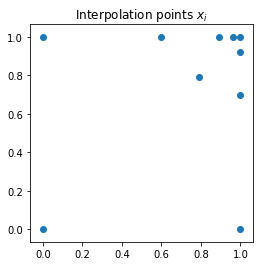

<IPython.core.display.Latex object>

[[1.1  1.1 ]
 [1.47 1.1 ]
 [1.1  1.64]
 [2.1  1.1 ]
 [1.1  1.25]
 [1.1  2.1 ]
 [1.19 1.1 ]
 [2.1  2.1 ]
 [1.38 1.37]
 [1.1  1.15]]


In [14]:
interp_points_array = np.array(interp_points)
fig = plt.figure(figsize=(4, 4))
plt.scatter(x = interp_points_array[:,1] / n_x_grid, y = interp_points_array[:,0] / n_x_grid)
plt.title(r'Interpolation points $x_i$')
plt.show()

display(Latex(rf'Selected parameters $\mu_i$ to build $q_i$:'))
print(rf'{mu_grid_list[selected]}')

# Step 7 - Lets look at error curves

### We must generate a new dictionary - a _test set_ - and evaluate the quality of our interpolations. 

We take a random selection of $\mu$ from $\mathcal{U}$. Recall that the limits of $\mathcal{U}$ are in ```mu_lims```. We call this test set $\mathcal{T_e}$

Then we look at the biggest $L^\infty$ error for each of these $\mu$, that is we consider

$$
\large
e_{n} = \max_{\mu \in \mathcal{T_e}} \| y(x, \mu) - \mathcal{I}_n[y(x, \mu)] \|_{\infty}
$$

In [15]:
# Lets generate a random set of mu on the domain of size n_test
n_test = 100

# What were the limits of the domain for mu again?
print('mu_lims =', mu_lims)

mu_test_list_1 = np.random.random(n_test) * (mu_lims[0][1] - mu_lims[0][0]) + mu_lims[0][0]
mu_test_list_2 = np.random.random(n_test) * (mu_lims[1][1] - mu_lims[1][0]) + mu_lims[1][0]
mu_test_list = np.vstack((mu_test_list_1, mu_test_list_2)).T

print('First 10 mu_test_list =')
print(mu_test_list[:10])

mu_lims = [[1.1, 2.1], [1.1, 2.1]]
First 10 mu_test_list =
[[1.51748784 1.67981693]
 [1.50920808 1.48345362]
 [1.71997017 1.61272585]
 [1.50555448 2.08450473]
 [1.10050271 1.57956971]
 [1.26017538 1.19230344]
 [2.01348056 1.24784163]
 [1.24392764 1.53049815]
 [1.41328561 1.27501275]
 [1.53459652 1.8259709 ]]


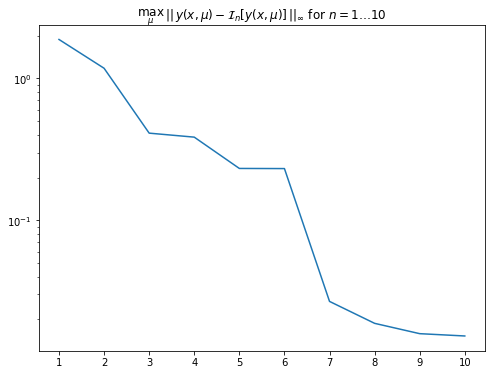

In [17]:
errors = np.zeros((n_test, len(interp_funcs)))

for n in range(1,len(interp_funcs)+1):
    
    # ===================
    #  FILL IN CODE HERE
    # ===================
    # 1. Build the B matrix up to an n x n system
    # for mu_i, mu_test in enumerate(mu_test_list):
    # 2. Eval y for mu_test
    # 3. interpolate y_test
    # 4. calculate L_inf error
    B = build_B_matrix(interp_funcs[:n], interp_points[:n])
    B_inv = np.linalg.inv(B)    
    for mu_i, mu_test in enumerate(mu_test_list):
        y_test = eval_y_on_grid(mu_test)
        y_test_interp = interpolator(y_test, B_inv, interp_funcs[:n], interp_points[:n])
    
        errors[mu_i, n-1] = (y_test - y_test_interp).max()
        
fig = plt.figure(figsize=(8, 6))
plt.semilogy(range(1,len(interp_funcs)+1), errors.max(axis = 0))
plt.title(rf'$\max_{{\mu}} \, || \, y(x, \mu) - \mathcal{{I}}_n[y(x, \mu)] \, ||_{{\infty}}$ for $n=1\ldots {len(interp_funcs)} $')
plt.xticks(range(1,len(interp_funcs)+1))
plt.show()

# Step 6 - Bonus for the adventurous: 
### Solve a family of parametric PDEs and apply the EIM

As a take-home exercise the following code could be used to approximate the solutions of the PDE

$$\large
- \mathrm{div}\cdot(a(\mu) \nabla y) = f
$$
where
$$\large
a(\mu) = \bar{a} + \sum_{i=1}^4 \mu_i \chi_{\mathcal{D}_i}(x)
$$
where the $\mathcal{D}_i$ are partitions of the unit square in to the 4 even sub-squares.

The solution $\large y(x, \mu)$ depends on $\large x \in \mathcal{D} = [0,1]^2$, and the parameter $\large \mu \in \mathcal{U} \subset \mathbb{R}^4$ can have some range that we define. Below is a very primitive finite element method (FEM) solver of the PDE that gives a coarse solution.

In [18]:
import scipy.sparse
import scipy.sparse.linalg

# The spatial grid on which we solve the PDE is of size (2**div x 2**div)
div = 5
n_side = 2**div - 1
n_el = n_side * n_side
h = 1.0 / (n_side + 1)

def solve_PDE_FEM(mu):
    # a is assumed to be a 2x2 array of positive values. This routine returns the solution
    # of the PDE on a grid of size 2^div by 2^div
    a = mu.repeat(2**(div - 1), axis=0).repeat(2**(div - 1), axis=1)

    # Now we make the various diagonals
    diag = 2.0 * (a[:-1, :-1] + a[:-1,1:] + a[1:,:-1] + a[1:, 1:]).flatten()
    # min_diag is below the diagonal, hence deals with element to the left in the FEM grid
    lr_diag = -(a[1:, 1:] + a[:-1, 1:]).flatten()
    lr_diag[n_side-1::n_side] = 0 # These corresponds to edges on left or right extreme
    lr_diag = lr_diag[:-1]

    # Far min deals with the element that is above
    ud_diag = -(a[1:-1, 1:] + a[1:-1, :-1]).flatten()

    A = scipy.sparse.diags([diag, lr_diag, lr_diag, ud_diag, ud_diag], [0, -1, 1, -n_side, n_side]).tocsr()
    f = 0.5 * h * h * np.ones(n_el)

    u_flat = scipy.sparse.linalg.spsolve(A, f)
    return np.pad(u_flat.reshape((n_side, n_side)), ((1,1),(1,1)), 'constant')

pde_x1_grid, pde_x2_grid = np.meshgrid(np.linspace(0, 1, 2**div+1, endpoint=True), 
                                       np.linspace(0, 1, 2**div+1, endpoint=True))

def plot_PDE_soln(vals, ax, title=None, alpha=0.7):
    # A routine that just plots a function that is assumed to be evaluated 
    # on a the grid of points - vals is assumed to be a square array
    # (note that x1_grid and x2_grid will be defined below)
    wframe = ax.plot_surface(pde_x1_grid, pde_x2_grid, vals, cstride=2, rstride=2, 
                             alpha=alpha, cmap=cmap)
    
    ax.set_facecolor('white')
    if title is not None:
        ax.set_title(title)

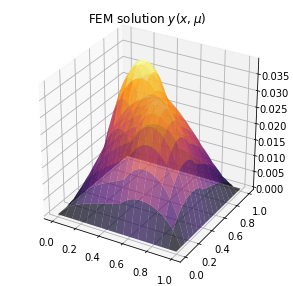

In [19]:
mu = np.array([[1, 0.3], [0.2, 0.8]])
y = solve_PDE_FEM(mu)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_PDE_soln(y, ax, title='FEM solution $y(x,\mu)$')
plt.show()

In [ ]:
# Lets generate a random set of mu, since we are in 4 dimensions
N_train = 1000

# Evenly distributed in (0.1, 1.1)^4
mu_train_list = np.random.random((N_train, 4)) + 0.1

training_set = [solve_PDE_FEM(mu) for mu in mu_train_list]